In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Пропущенные значения:
Цена на арматуру    0
dtype: int64


<Figure size 1200x600 with 0 Axes>

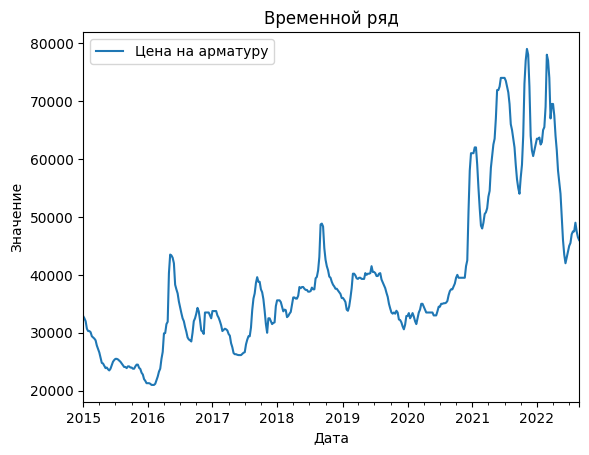

Результаты теста Дики-Фуллера:
p-value: 0.3199906102569917
Критические значения:
1%: -3.4470566389664703
5%: -2.8689037160476016
10%: -2.570692663557422


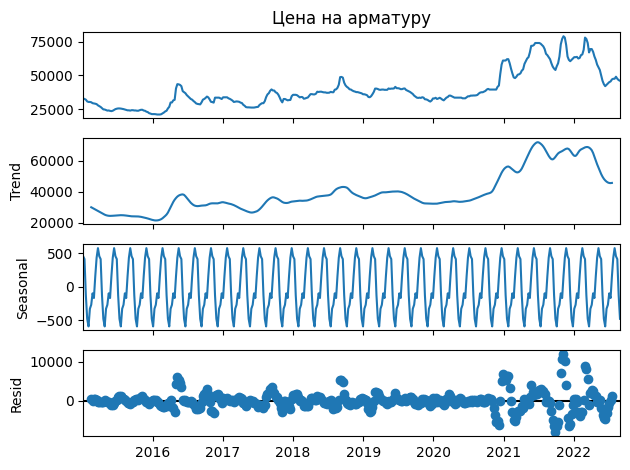

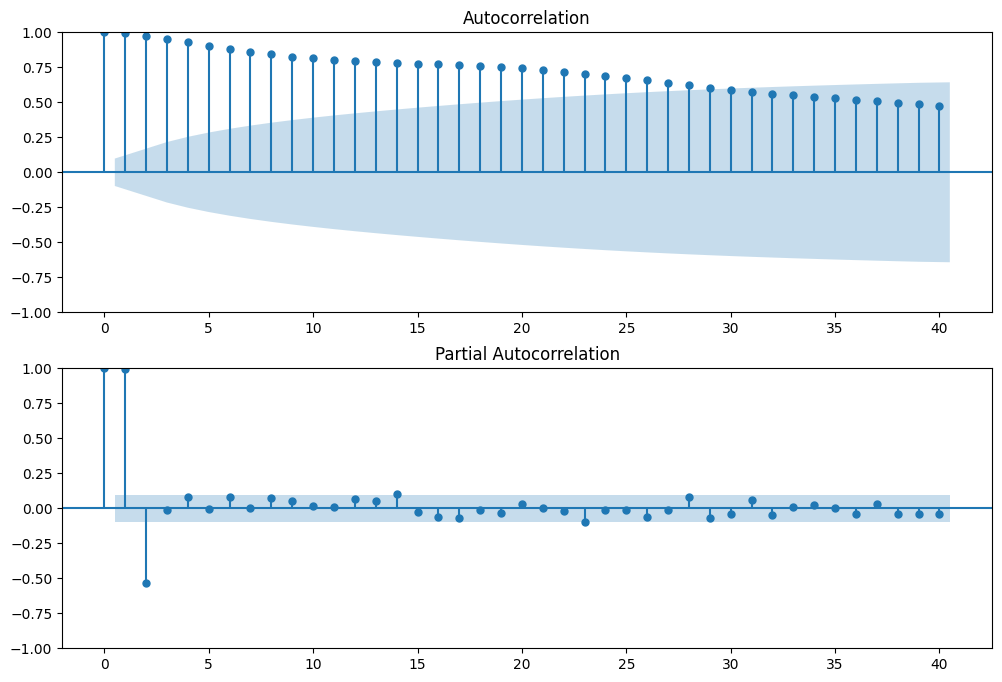

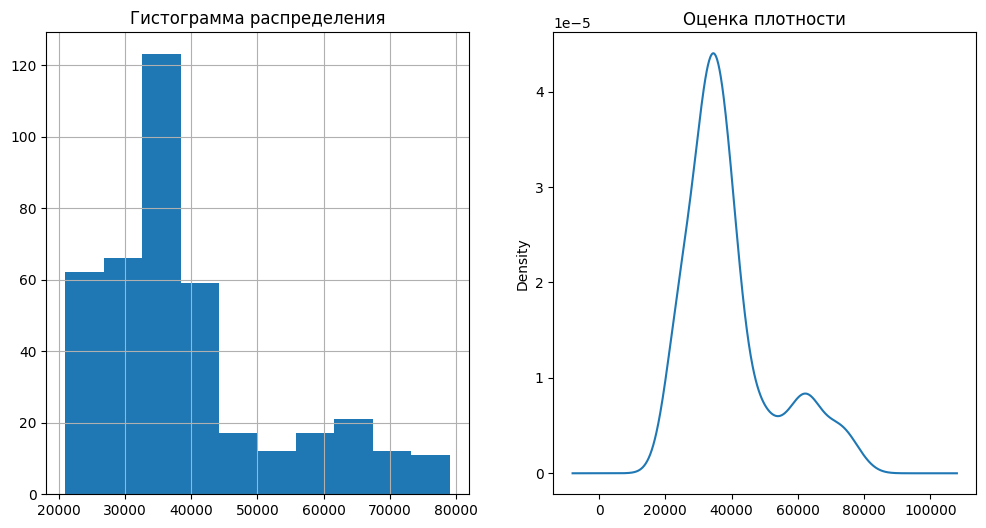

In [5]:
# 1. Загрузка данных
df = pd.read_excel('data/train.xlsx', parse_dates=['dt'], index_col='dt')

# 2. Проверка пропусков
print("Пропущенные значения:")
print(df.isnull().sum())

# 3. Визуализация ряда
plt.figure(figsize=(12,6))
df.plot(title='Временной ряд')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

# 4. Проверка стационарности (тест Дики-Фуллера)
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'p-value: {dftest[1]}')
    print(f'Критические значения:')
    for key, val in dftest[4].items():
        print(f'{key}: {val}')
        
test_stationarity(df['Цена на арматуру'])

# 5. Декомпозиция ряда
result = seasonal_decompose(df['Цена на арматуру'], model='additive', period=12)
result.plot()
plt.show()

# 6. Автокорреляция
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Цена на арматуру'].dropna(), lags=40, ax=ax1)
plot_pacf(df['Цена на арматуру'].dropna(), lags=40, ax=ax2)
plt.show()

# 7. Анализ распределения
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df['Цена на арматуру'].hist()
plt.title('Гистограмма распределения')
plt.subplot(1,2,2)
df['Цена на арматуру'].plot(kind='kde')
plt.title('Оценка плотности')
plt.show()

# Основные выводы

## Нестационарность ряда:
- **Тест Дики-Фуллера** показал:
  - p-value = 0.32 
  - Критические значения:
    - 1%: -3.45
    - 5%: -2.87
    - 10%: -2.57
- **Вывод**: ряд нестационарен (присутствуют тренд и/или сезонность)

## Сезонная декомпозиция:
- Четкий сезонный компонент:
  - Амплитуда ±500
- Остатки (Resid):
  - Сильные отклонения в 2020-2022 гг.
  - Возможные причины: пандемия, изменения рынка

## Автокорреляция (ACF/PACF):
- **ACF**:
  - Медленное затухание → подтверждение нестационарности
- **PACF**:
  - Значимые пики на первых лагах
  - Рекомендация: дифференцирование (первая разница)

## Распределение данных:
- Гистограмма и плотность показывают:
  - Правосторонняя асимметрия
  - Смещение к высоким значениям
- **Рекомендация**:
  - Преобразование данных (логарифмирование)